# Part B

Modelling over a mass distribution using IMF

In [ ]:
%pip install numpy matplotlib

In [11]:

import numpy as np
import matplotlib.pyplot as plt
from subprocess import run
import os
import mesa_reader


In [12]:

def salpeter_imf(mass_min, mass_max, num_stars):
    """Generate masses following Salpeter IMF: dN/dM ∝ M^(-2.35)"""
    alpha = -2.35
    u = np.random.random(num_stars)
    alpha1 = alpha + 1
    m1 = mass_min**alpha1
    m2 = mass_max**alpha1
    masses = (m1 + (m2 - m1)*u)**(1/alpha1)
    return masses

In [13]:
def inlist_pgstar(mass):
    return f"""
&pgstar
  ! see star/defaults/pgstar.defaults

  ! MESA uses PGPLOT for live plotting and gives the user a tremendous
  ! amount of control of the presentation of the information.

  ! show HR diagram
  ! this plots the history of L,Teff over many timesteps

    TRho_Profile_win_width = 6
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_win_flag = .true.
    TRho_Profile_file_flag = .true.
    TRho_Profile_file_dir = 'pgstar_out_{mass}'
    TRho_Profile_file_prefix = 'trho_pgstar_{mass}'
    TRho_Profile_file_interval = 50
    TRho_Profile_win_width = 9
    TRho_Profile_win_aspect_ratio = 1.0
    TRho_Profile_title = 'TRho'


  ! set static plot bounds
    HR_logT_min = 3.5
    HR_logT_max = 4.6
    HR_logL_min = 2.0
    HR_logL_max = 6.0

  ! set window size (aspect_ratio = height/width)
    HR_win_width = 6
    HR_win_aspect_ratio = 1.0
    HR_win_flag = .true.
    HR_file_flag = .true.
    HR_file_dir = 'pgstar_out'
    HR_file_prefix = 'hr_pgstar_'
    HR_file_interval = 50
    HR_win_width = 9
    HR_win_aspect_ratio = 1.0
    HR_title = 'HR'



  ! show temperature/density profile
  ! this plots the internal structure at single timestep
    TRho_Profile_win_flag = .true.

  ! add legend explaining colors
    show_TRho_Profile_legend = .true.

  ! display numerical info about the star
    show_TRho_Profile_text_info = .true.

  ! set window size (aspect_ratio = height/width)
    TRho_Profile_win_width = 8
    TRho_Profile_win_aspect_ratio = 0.75

/ ! end of pgstar namelist
"""


def inlist_project(mass):
    return f"""
&star_job

    create_pre_main_sequence_model = .true.

    save_model_when_terminate = .false.
    save_model_filename = '15M_at_TAMS.mod'

    pgstar_flag = .true.

/ 


&kap
  use_Type2_opacities = .true.
  Zbase = 0.02

/

&controls
    initial_mass = {mass} ! in Msun units
    initial_z = 0.02

    Lnuc_div_L_zams_limit = 0.99d0
    stop_near_zams = .true.

    xa_central_lower_limit_species(1) = 'h1'
    xa_central_lower_limit(1) = 1d-3

     energy_eqn_option = 'dedt'
     use_gold_tolerances = .true.


/
"""

In [29]:
mass_l_t = dict()
def run_mesa_models(masses):
    """Run MESA for each mass in the distribution"""
    results = []
    for mass in masses:
        with open('star/inlist_pgstar', 'w') as f:
            f.write(inlist_pgstar(mass))
        
        with open('star/inlist_project', 'w') as f:
            f.write(inlist_project(mass))
        
        # run(['cd star'], check=True)
        run(['pwd'], check=True)
        run(['ls'], check=True)
        os.chdir("./star")
        run(['pwd'], check=True)
        run(['./mk'], check=True)
        run(['./rn'], check=True)
        os.chdir("../")
        
        if os.path.exists('star/LOGS/history.data'):
            results.append({'mass': mass, 'success': True})
        else:
            results.append({'mass': mass, 'success': False})

        mr = mesa_reader.MesaData(file_name='./star/LOGS/history.data')
        mass_l_t[mass] = (mr.log_L, mr.log_Teff)
    return results


  

In [18]:
def plot_hr_diagram(masses):
    """Plot HR diagram for all stars in the same plot"""
    plt.figure()
    for mass in masses:
        plt.plot(mass_l_t[mass][1], mass_l_t[mass][0], label=f'{mass:.2f} Msun')
    plt.gca().invert_xaxis()
    plt.xlabel('log(Teff)')
    plt.ylabel('log(L)')
    plt.legend()
    plt.show()

/root/astrolab
mass_dist.py
mass_distribution.png
partA.ipynb
partB.ipynb
star
/root/astrolab/star
gfortran -fopenmp -o ../star  run_star_extras.o run_star.o  run.o  -L/root/mesa-24.08.1/lib -lstar -lgyre_mesa -lgyre -lionization -latm -lcolors -lturb -lstar_data -lnet -leos -lkap -lrates -lneu -lchem -linterp_2d -linterp_1d -lnum -lauto_diff -lforum -lmtx -lconst -lmath -lutils `mesasdk_crmath_link` `mesasdk_lapack95_link` `mesasdk_lapack_link` `mesasdk_blas_link` `mesasdk_hdf5_link`  `mesasdk_pgplot_link` -lz 


/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-02-18
TIME: 21:30:10
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.478558   2775.503 -19.858070 -19.858070   0.102827   0.102827   0.700000   0.001010   0.280000  -3.655441    594      0
-4.8416E+00   5.478530   0.505777 -99.000000 -21.255926 -99.000000   0.000000   0.280000   0.009381   0.020000   0.308699      2
 3.6400E-05  -1.386787  -0.260386 -99.000000 -99.000000  -7.321227   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.478558   2775.549 -19.858070 -19.858070   0.102827   0.102827   0.700000   0.001010   0.280000  -3.655441    594      0
-4.7625E+00   5.478530   0.505778 -99.000000 -21.255926 -99.000000   0.000000   0.280000   0.009381   0.020000   0.308699      2
 5.3680E-05  -1.386787  -0.260355 -99.000000 -99.000000  -7.321244   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.478558   2775.605 -19.858070 -19.858070   0.102827   0.102827   0.700000   0.001010   0.280000  -3.655441    594      0
-4.6833E+00   5.478530   0.505780 -99.000000 -21.255926 -99.

/root/mesasdk/bin/../lib/gcc/x86_64-pc-linux-gnu/13.3.0/../../../../x86_64-pc-linux-gnu/bin/ld: warning: atm_support.o: requires executable stack (because the .note.GNU-stack section is executable)


DATE: 2025-02-18
TIME: 21:36:27
 reading user weak rate file /root/mesa-24.08.1/data/rates_data/rate_tables/S13_r_be7_wk_li7.h5
 version_number r24.08.1
 read inlist_project


 The terminal output contains the following information

      'step' is the number of steps since the start of the run,
      'lg_dt' is log10 timestep in years,
      'age_yr' is the simulated years since the start run,
      'lg_Tcntr' is log10 center temperature (K),
      'lg_Dcntr' is log10 center density (g/cm^3),
      'lg_Tmax' is log10 max temperature (K),
      'Teff' is the surface temperature (K),
      'lg_R' is log10 surface radius (Rsun),
      'lg_L' is log10 surface luminosity (Lsun),
      'lg_LH' is log10 total PP and CNO hydrogen burning power (Lsun),
      'lg_L3a' is log10 total triple-alpha helium burning power (Lsun),
      'lg_gsurf' is log10 surface gravity,
      'lg_LNuc' is log10 nuclear power (Lsun),
      'lg_LNeu' is log10 total neutrino power (Lsun),
      'lg_Lphoto' is log10 to

PGPLOT /xw: cannot connect to X server [:0]
PGPLOT /xw: cannot connect to X server [:0]


          3   5.477724   3019.155 -20.031096 -20.031096   0.147140   0.147140   0.700000   0.001010   0.280000  -4.312460    587      0
-4.8416E+00   5.477698   0.657400 -99.000000 -21.428958 -99.000000   0.000000   0.280000   0.009381   0.020000   0.247983      2
 3.6400E-05  -1.674622   0.189035 -99.000000 -99.000000  -7.401690   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          4   5.477724   3019.252 -20.031096 -20.031096   0.147140   0.147140   0.700000   0.001010   0.280000  -4.312460    587      0
-4.7625E+00   5.477698   0.657400 -99.000000 -21.428958 -99.000000   0.000000   0.280000   0.009381   0.020000   0.247983      2
 5.3680E-05  -1.674622   0.189092 -99.000000 -99.000000  -7.401652   0.000000   0.003447   0.002085   0.020000  0.000E+00  max increase

          5   5.477724   3019.367 -20.031096 -20.031096   0.147140   0.147140   0.700000   0.001010   0.280000  -4.312460    587      0
-4.6833E+00   5.477698   0.657401 -99.000000 -21.428958 -99.

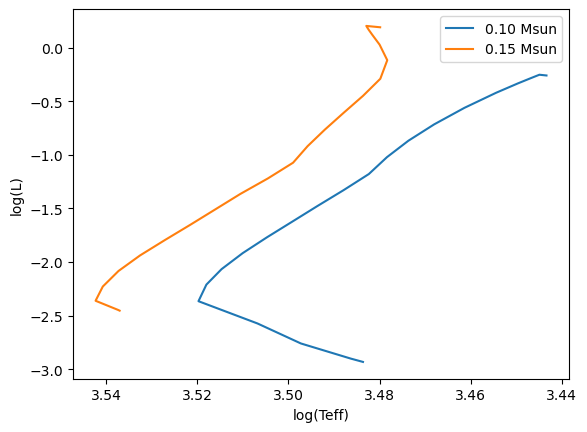

In [ ]:
masses = salpeter_imf(0.1, 50, 2)
run_mesa_models(masses)
plot_hr_diagram(masses)

In [ ]:

def analyze_distribution(masses):
    
    plt.figure(figsize=(10, 6))
    plt.hist(masses, bins=50, density=True, alpha=0.6, label='Generated Distribution')
    
    mass_range = np.linspace(0.1, 50, 1000)
    salpeter = mass_range**(-2.35)
    salpeter /= np.trapz(salpeter, mass_range)  # Normalize
    plt.plot(mass_range, salpeter, 'r-', label='Salpeter IMF')
    
    plt.xlabel('Mass (Solar Masses)')
    plt.ylabel('Normalized Frequency')
    plt.title('Generated Mass Distribution vs Salpeter IMF')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    # plt.savefig('mass_distribution.png')
    plt.show()
    
    print("Running MESA models...")
    results = run_mesa_models(masses)
    
    successful_runs = sum(1 for r in results if r['success'])
    print(f"Successfully ran {successful_runs} out of {len(masses)} models")
    
    return results

In [8]:
results = analyze_distribution()


/tmp/ipykernel_47542/1495933126.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  salpeter /= np.trapz(salpeter, mass_range)  # Normalize


Running MESA models...


FileNotFoundError: [Errno 2] No such file or directory: 'inlist_project'